# MAE arvutused regressioonide ja otsustuspuuga 

**Teegid**

In [1]:
# arvutamine ja joonistamine
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# treenimine, tulemused
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# regressorid
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


**Andmed ja puhastamine**

In [2]:
# laen treening- ja testandmed
train =  pd.read_csv('df_clean.csv')
test = pd.read_csv('df_clean_test.csv')

In [3]:
train.shape

(8592, 25)

In [4]:
test.shape

(168, 24)

In [5]:
pd.set_option('display.max_columns', 500)
train.head()

,Unnamed: 0,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,timestamp,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577,2021-09-01 00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594,2021-09-01 01:00:00,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685,2021-09-01 02:00:00,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016,2021-09-01 03:00:00,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677,2021-09-01 04:00:00,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5


In [6]:
train.dtypes

Unnamed: 0                     int64
time                          object
temp                         float64
dwpt                         float64
rhum                         float64
prcp                         float64
snow                         float64
wdir                         float64
wspd                         float64
wpgt                         float64
pres                         float64
coco                         float64
el_price                     float64
consumption                  float64
timestamp                     object
datetime                      object
year                           int64
month                          int64
day                            int64
weekday                        int64
hour                           int64
date                          object
is_holiday                      bool
season                        object
google_trends_electricity      int64
dtype: object

In [7]:
# ühendan (ajutiselt) treening- ja testandmestiku, et viia puhastamine läbi ühise andmestiku peal
train_vahe = train.drop(['consumption'],axis=1)
train_vahe['train']=1
test_vahe = test
test_vahe['train']=0
train_test=pd.concat([train_vahe,test_vahe])

In [8]:
train_test.shape

(8760, 25)

In [9]:
# eemaldan veerud, mida ei vaja analüüsiks
train_test = train_test.drop(columns=['Unnamed: 0', 'time', 'timestamp', 'datetime', 'date'])

In [10]:
# is_holiday booleanist täisarvuks
train_test["is_holiday"] = train_test["is_holiday"].astype(int)

In [11]:
train_test=pd.get_dummies(train_test)

In [12]:
train_test.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month,day,weekday,hour,is_holiday,google_trends_electricity,train,season_Autumn,season_Spring,season_Summer,season_Winter
0,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,2.0,0.09016,2021,9,1,2,0,0,5,1,1,0,0,0
1,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,2.0,0.09251,2021,9,1,2,1,0,5,1,1,0,0,0
2,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,2.0,0.08890,2021,9,1,2,2,0,5,1,1,0,0,0
3,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,1.0,0.08735,2021,9,1,2,3,0,5,1,1,0,0,0
4,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,2.0,0.08688,2021,9,1,2,4,0,5,1,1,0,0,0


In [13]:
# normaliseerin andmed
train_test=(train_test-train_test.min())/(train_test.max()-train_test.min())

In [14]:
train_test.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month,day,weekday,hour,is_holiday,google_trends_electricity,train,season_Autumn,season_Spring,season_Summer,season_Winter
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.575026,0.633145,0.712915,0.002455,0.004836,0.558018,0.288714,0.297010,0.597020,0.191689,0.041149,0.665639,0.502439,0.490700,0.499543,0.500000,0.032877,0.369488,0.980822,0.249429,0.251941,0.252055,0.246575
std,0.162253,0.166682,0.218779,0.031798,0.052988,0.246342,0.152588,0.165456,0.147128,0.198909,0.031501,0.471793,0.313458,0.293248,0.333009,0.300982,0.178324,0.192332,0.137158,0.432707,0.434152,0.434217,0.431042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.462609,0.520161,0.575000,0.000000,0.000000,0.388889,0.227129,0.168053,0.519435,0.080000,0.023265,0.000000,0.272727,0.233333,0.166667,0.250000,0.000000,0.273684,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.566957,0.620968,0.787500,0.000000,0.000000,0.583333,0.227129,0.259567,0.614252,0.120000,0.034519,1.000000,0.545455,0.500000,0.500000,0.500000,0.000000,0.305263,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.692174,0.768145,0.887500,0.000000,0.000000,0.750000,0.340694,0.414309,0.684335,0.200000,0.050003,1.000000,0.818182,0.733333,0.833333,0.750000,0.000000,0.452632,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# eraldan uuesti treening- ja testandmestiku
train_df=train_test[train_test['train']==1]
test_df=train_test[train_test['train']==0]
train_df=train_df.drop(['train'],axis=1)
test_df=test_df.drop(['train'],axis=1)

In [16]:
# lisan treeningandmestikule tagasi 'consumption' atribuudi
train_df = pd.concat([train_df,train['consumption']], axis=1)

In [17]:
train_df.shape

(8592, 23)

In [18]:
test_df.shape

(168, 22)

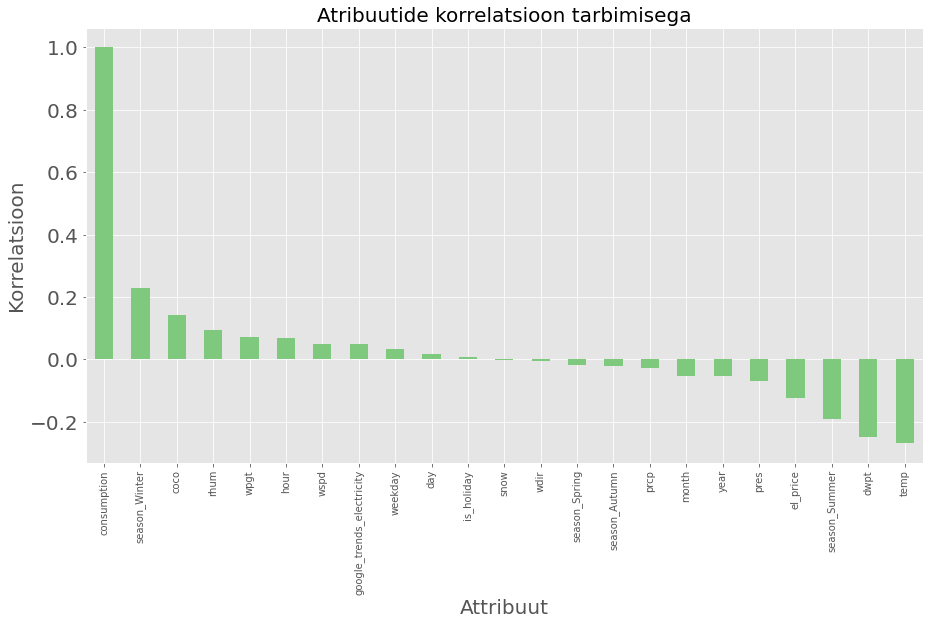

In [19]:
# illustreerin teiste atribuutide korrelatsiooni 'consumption'iga

plt.figure(figsize=(15,8))
plt.style.use('ggplot')

my_cmap = cm.get_cmap('Accent')

train_df.corr()['consumption'].sort_values(ascending = False).plot(kind='bar', cmap=my_cmap)

plt.title('Atribuutide korrelatsioon tarbimisega',fontsize=20)
plt.xlabel('Attribuut', fontsize=20)
plt.ylabel('Korrelatsioon',fontsize=20)

plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 20) 
plt.grid(True)
plt.show() 

**Lineaarregressioon**

In [20]:
y_lr = train_df['consumption']
X_lr = train_df.drop(['consumption'],axis=1)
train_X, val_X, train_y, val_y = train_test_split(X_lr, y_lr,random_state=0, test_size = 0.20)

In [21]:
model_lr = LinearRegression()
model_lr.fit(train_X, train_y)
val_predictions_lr = model_lr.predict(val_X)

In [22]:
mean_absolute_error(val_y, val_predictions_lr)

0.6040714330090525

In [23]:
# katse ristvalideerimisega

model_lr = LinearRegression()

n_folds = 4
fold_MAEs = np.zeros(n_folds)

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

folds = KFold(n_splits=n_folds, shuffle=True, random_state=0)

folds.get_n_splits(X, y)

fold_indx = 1

for train_index, val_index in folds.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model_lr.fit(X_train, y_train)

  val_predictions = model_lr.predict(X_val)
  fold_MAEs[fold_indx-1] = mean_absolute_error(y_val, val_predictions)

  fold_indx += 1

print(f'Keskmine valideerimisvalimi MAE on {np.mean(fold_MAEs)}') 


Keskmine valideerimisvalimi MAE on 0.6053018360936587


Ristvalideerimine midagi juurde ei andnud, tulemus veidi halvem.

In [24]:
model_lr = LinearRegression()
model_lr.fit(X_lr, y_lr) #siin ei ole nüüd seda train-test splitti

LinearRegression()

In [25]:
test_y_ennustused_lr = model_lr.predict(test_df)

In [26]:
# genereerin Kaggle'i ennustuste faili
submission_lr = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_lr},
    columns = ['time', 'consumption'])
submission_lr.to_csv('submission_lr.csv', index = False)

Kaggle'i tulemuseks andis 0.44184.

**Ridge, Lasso ja ElasticNet regressioonid**

In [27]:
lambda_ = 1

lr = LinearRegression()
lr_ridge = Ridge(lambda_)
lr_lasso = Lasso(lambda_)
lr_elastic = ElasticNet(alpha = lambda_)

lr.fit(X_lr, y_lr)
lr_ridge.fit(X_lr, y_lr)
lr_lasso.fit(X_lr, y_lr)
lr_elastic.fit(X_lr, y_lr)

predict_lr = lr.predict(val_X)
predict_ridge = lr_ridge.predict(val_X)
predict_lasso = lr_lasso.predict(val_X)
predict_elastic = lr_elastic.predict(val_X)

In [28]:
mae_lrr = mean_absolute_error(val_y, predict_lr)
print(f'Valideerimisvalimi lineaarregressiooni MAE on {mae_lrr}.')

mae_ridge = mean_absolute_error(val_y, predict_ridge)
print(f'Valideerimisvalimi ridge regressiooni MAE on {mae_ridge}.')

mae_lasso = mean_absolute_error(val_y, predict_lasso)
print(f'Valideerimisvalimi lasso regressiooni MAE on {mae_lasso}.')

mae_elastic = mean_absolute_error(val_y, predict_elastic)
print(f'Valideerimisvalimi elasticnet regressiooni MAE on {mae_elastic}.')


Valideerimisvalimi lineaarregressiooni MAE on 0.6006756380890054.
Valideerimisvalimi ridge regressiooni MAE on 0.6012899604219334.
Valideerimisvalimi lasso regressiooni MAE on 0.6684276661840554.
Valideerimisvalimi elasticnet regressiooni MAE on 0.6684276661840554.


In [29]:
# genereerin Kaggle'i ennustuste faili RIDGE jaoks
lambda_ = 1 
model_ridge = Ridge(lambda_)
model_ridge.fit(X_lr, y_lr) 
test_y_ennustused_ridge = model_ridge.predict(test_df)

In [30]:
submission_ridge = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_ridge},
    columns = ['time', 'consumption'])
submission_ridge.to_csv('submission_ridge.csv', index = False)

Kaggle'i tulemuseks andis 0.40911.

In [31]:
# genereerin Kaggle'i ennustuste faili LASSO jaoks
lambda_ = 1 
model_lasso = Lasso(lambda_)
model_lasso.fit(X_lr, y_lr) 
test_y_ennustused_lasso = model_lasso.predict(test_df)

In [32]:
submission_lasso = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_lasso},
    columns = ['time', 'consumption'])
submission_lasso.to_csv('submission_lasso.csv', index = False)

Kaggle'i tulemuseks andis 0.59306.

**Otsustuspuu**

In [33]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50]

error = np.zeros(len(max_depths))

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

for i, depth in enumerate(max_depths):

  kf = KFold(n_splits=4, random_state=0, shuffle=True)

  fold_mae = []
  for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = DecisionTreeRegressor(max_depth = depth)

    model.fit(X_train, y_train) 

    predictions = model.predict(X_val)

    error_mae = mean_absolute_error(y_val, predictions)
    fold_mae.append(error_mae)

  print(f'Keskmine MAE sügavusele {depth} on {np.mean(fold_mae)}.')
  error[i] = np.mean(fold_mae)

Keskmine MAE sügavusele 1 on 0.6096382119397998.
Keskmine MAE sügavusele 2 on 0.6028876863326238.
Keskmine MAE sügavusele 3 on 0.5790933650985636.
Keskmine MAE sügavusele 4 on 0.574374340502702.
Keskmine MAE sügavusele 5 on 0.5551377285887014.
Keskmine MAE sügavusele 6 on 0.5452116418014454.
Keskmine MAE sügavusele 7 on 0.5411004960231558.
Keskmine MAE sügavusele 8 on 0.542967478316541.
Keskmine MAE sügavusele 9 on 0.541922394024945.
Keskmine MAE sügavusele 10 on 0.541535494712619.
Keskmine MAE sügavusele 11 on 0.5476523370453696.
Keskmine MAE sügavusele 12 on 0.5516267546344645.
Keskmine MAE sügavusele 13 on 0.5680368196629983.
Keskmine MAE sügavusele 14 on 0.5756310008923609.
Keskmine MAE sügavusele 15 on 0.5791369022064741.
Keskmine MAE sügavusele 20 on 0.6033803157638413.
Keskmine MAE sügavusele 30 on 0.6046469681098696.
Keskmine MAE sügavusele 40 on 0.6064135242085662.
Keskmine MAE sügavusele 50 on 0.6059870810055866.


Text(0, 0.5, 'MAE')

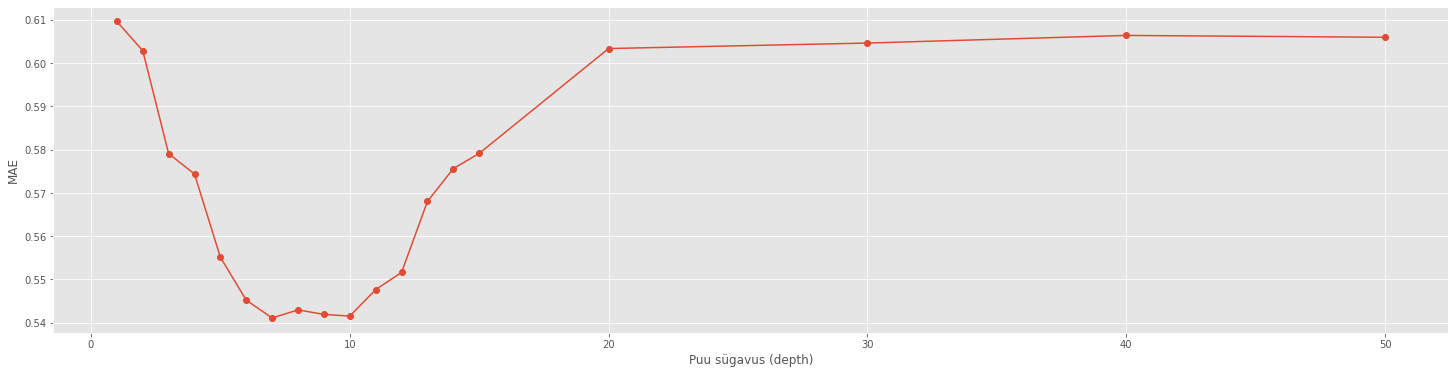

In [34]:
plt.figure(figsize=(25, 6))

plt.plot(max_depths, error, marker = 'o')
plt.xlabel('Puu sügavus (depth)')
plt.ylabel('MAE')

In [35]:
model_dt = DecisionTreeRegressor(max_depth = 9)
model_dt.fit(train_X, train_y)

predictions_dt = model_dt.predict(val_X)
mae_dt = mean_absolute_error(val_y, predictions_dt)

print(f'Otsustuspuu MAE on {mae_dt}.')

Otsustuspuu MAE on 0.5097244146589971.


In [36]:
model_Dt = DecisionTreeRegressor(max_depth = 9)
model_Dt.fit(X_lr, y_lr)

test_y_predictions_dt = model_Dt.predict(test_df)

In [37]:
submission_dt = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_predictions_dt},
    columns = ['time', 'consumption'])
submission_dt.to_csv('submission_dt.csv', index = False)

Kaggle'i tulemuseks andis 1.33609. Ju on tegu ülesobitamisega.

**Random Forest**

In [38]:
nr_trees = [50, 100, 500, 750, 1000]

error = np.zeros(len(nr_trees))

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

for i, tree in enumerate(nr_trees):

  kf = KFold(n_splits=4, random_state=0, shuffle=True)

  fold_mae = []
  for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = RandomForestRegressor(n_estimators = tree)

    model.fit(X_train, y_train) 

    predictions = model.predict(X_val)

    error_mae = mean_absolute_error(y_val, predictions)
    fold_mae.append(error_mae)

  print(f'Keskmine MAE {tree} puule on {np.mean(fold_mae)}')
  error[i] = np.mean(fold_mae)

Keskmine MAE 50 puule on 0.48361642923649906
Keskmine MAE 100 puule on 0.4782721426908752
Keskmine MAE 500 puule on 0.4772387399906891
Keskmine MAE 750 puule on 0.4758865282433271
Keskmine MAE 1000 puule on 0.4758690811219739


Text(0, 0.5, 'MAE')

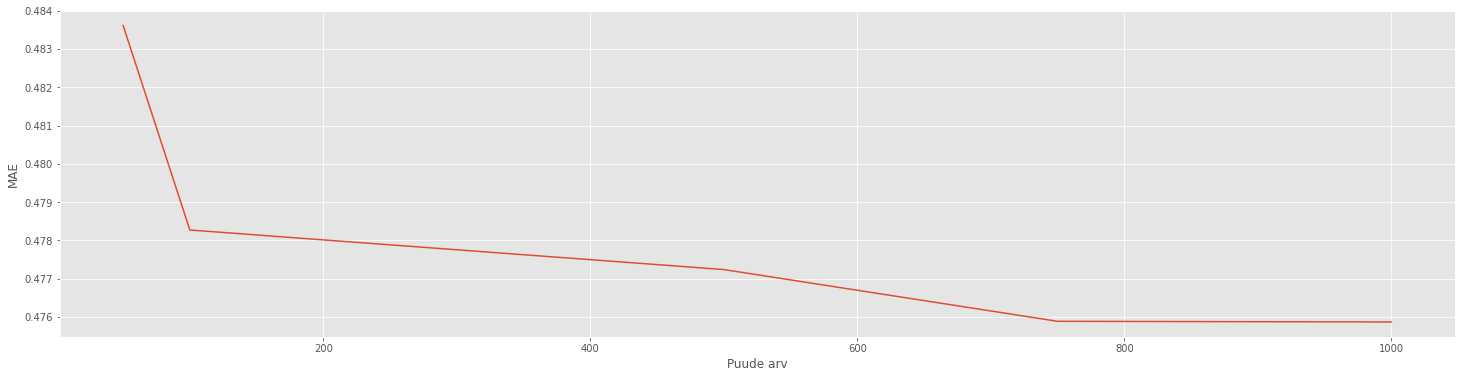

In [39]:
plt.figure(figsize=(25, 6))

plt.plot(nr_trees, error)
plt.xlabel('Puude arv')
plt.ylabel('MAE')

In [40]:
model_rf = RandomForestRegressor(n_estimators = 500)
model_rf.fit(train_X, train_y)

predictions_rf = model_rf.predict(val_X)
mae_rf = mean_absolute_error(val_y, predictions_rf) 

print(f'MAE Random Foresti puhul on {mae_rf}')

MAE Random Foresti puhul on 0.46152981966259454


In [41]:
model_rf = RandomForestRegressor(n_estimators=500)
model_rf.fit(X_lr, y_lr)

test_y_ennustused_rf = model_rf.predict(test_df)

In [42]:
submission_rf = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_rf},
    columns = ['time', 'consumption'])
submission_rf.to_csv('submission_rf.csv', index = False)

Kaggle'i tulemuseks andis .